In [27]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [28]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 583kB 6.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 47.1.1
    Uninstalling setuptools-47.1.1:
      Successfully uninstalled setuptools-47.1.1


In [5]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import time
import os
from PIL import Image
import cv2
import pandas as pd
from collections import Counter
from random import shuffle
from PIL import Image
import cv2
import glob
import io
import base64

In [6]:
from google.colab import drive

drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2020/BREAKOUT/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# BREAKOUT PROJECT

## Environment Information

In [6]:
env=gym.make("Breakout-v0")
print('Number of possible actions:',env.action_space)
print('Observation space (information for the agent:',env.observation_space)
print('Number of lifes per game:',5)
print('Action meanings:')
i=0
for act in env.env.get_action_meanings():
    print('  Action:',i, '  ',act)
    i=i+1

Number of possible actions: Discrete(4)
Observation space (information for the agent: Box(210, 160, 3)
Number of lifes per game: 5
Action meanings:
  Action: 0    NOOP
  Action: 1    FIRE
  Action: 2    RIGHT
  Action: 3    LEFT


In [29]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [30]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Random Agent

Our first approach is to have a random agent playing matches. As we can see the average reward per match is very low.

In [15]:
for i in range(0,1):
    env=wrap_env(gym.make("Breakout-v0"))
    env.reset()
    done=False
    while not done:
        #env.render()
        action=np.random.randint(0,4)
        state, reward, done, info=env.step(action)
    env.close()
    show_video()

## AI Agent

This agent will play by trying to locate the ball and the paddle with a simple algorithm and move according to this information.

In [16]:
#Color of the ball and the paddle
color=[200,72,72]

# Checks if a position has the ball and paddle color.
def check_color(i,j,observation):
    for k in range(0,3):
        if observation[i][j][k]!=color[k]:
            return 0
    return 1

# Calculates the x-coordinate of the paddle (center).
def calculate_paddle(observation):
    exit=0
    i=192
    for j in range(10, 152):
        exit=check_color(i,j,observation)
        if(exit==1):
            exit2=0
            for w in range(j, j+10):
                exit2=check_color(i,w,observation)
                if(exit2!=1):
                    break
            if(exit2==1):
                break
    if exit2==0:
        return -1
    return j+12

# Calculates the x-coordinate of the ball in case the ball exists and it's near the paddle.
def calculate_ball(observation):
    exit=0
    for i in range(90,192):
        for j in range(10, 152):
            exit=check_color(i,j,observation)
            if(exit==1):
                break
        if(exit==1):
            break
    if exit==0:
        return -1
    return j+2

In [19]:
for i in range(0,1):
    env=wrap_env(gym.make("Breakout-v0"))
    env.reset()
    done=False
    lives=6
    action=1
    while not done:
        state, reward, done, info=env.step(action)
        x1=calculate_paddle(state)
        x2=calculate_ball(state)
        if(info['ale.lives']!=lives):
            lives=info['ale.lives']
            action=1
        else:
            action = 1
            if x1!=-1 and x2!=-1:
                if x1>x2:
                    action=3
                elif x1<x2:
                    action=2
                else:
                    action=1
        #env.render()
    env.close()
    show_video()

## Supervised Learning Agent

This agent will try to learn by imitation. We let the AI play some games and used the data generated to train a neural network model.

### Step1: Screen Modification

We decided to reduce the inputs for the neural network to 84x84x3. The reason is basically that some parts of the image such as the score are not needed for deciding the outputs. This also increments the computation and accuracy speed. This input is the concatenation of the current frame in grayscale with the two previous frames

In [8]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize((84, 84), interpolation=Image.CUBIC),
                    T.ToTensor()])
def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    screen = env.render(mode='rgb_array')
    screen=cv2.cvtColor(screen,cv2.COLOR_BGR2GRAY).reshape(1,210,160)
    _, screen_height, screen_width = screen.shape
    view_width = int(screen_width * 0.9)
    cart_location = int(screen_width/2)
    slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
        
    slice_range2 = slice(60,
                            screen_height)
    screen = screen[:, slice_range2,slice_range]
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

torch.Size([1, 3, 84, 84])
(1, 3, 84, 84)


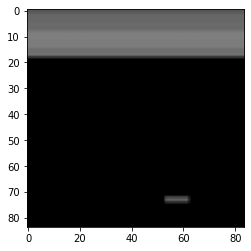

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Visualizing the input image
env = gym.make("Breakout-ram-v0").unwrapped
w=env.reset()
past_frame1 = get_screen()
past_frame2 = get_screen()
current_screen = get_screen()
state=torch.cat((past_frame1,past_frame2,current_screen), 1)
print(state.shape)
plt.imshow(np.array(state[0]).transpose(1,2,0))
env.close()
print(state.numpy().shape)

### Step2: Generating the data

We adapted the previous code to save the data generated by the AI agent and train with it.

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#This file will save the data. We check if it exists to append the new data or create a new file.
filename=data_path+'breakout_user_data.npy'
if os.path.isfile(filename):
    print('File already exists, loading data')
    training_data=list(np.load(filename,allow_pickle=True))
else: 
    print('File does not exist, creating new data')
    training_data=[]

for i in range(0,30):
    print('Playing game ',i)
    env=gym.make("Breakout-v0")
    env.reset()
    done=False
    lives=6
    action=1
    past_frame1 = get_screen()
    past_frame2 = get_screen()
    current_screen = get_screen()
    state=torch.cat((past_frame1,past_frame2,current_screen), 1)
    while not done:
        state1, reward, done, info=env.step(action)
        x1=calculate_paddle(state1)
        x2=calculate_ball(state1)
        if(info['ale.lives']!=lives):
            lives=info['ale.lives']
            action=1
        else:
            action = 1
            if x1!=-1 and x2!=-1:
                if x1>x2:
                    action=3
                elif x1<x2:
                    action=2
                else:
                    action=1
        output=action
        past_frame2 = past_frame1
        past_frame1 = current_screen
        current_screen = get_screen()
        if not done:
            next_state = torch.cat((past_frame1,past_frame2,current_screen), 1)
            state = next_state
            training_data.append([state[0].numpy(),output])
        else:
            next_state = None
    env.close()
np.save(filename,training_data)
print('File saved successfully')

File does not exist, creating new data
Playing game  0
Playing game  1
Playing game  2


### Step3: Balance data

In this case we are interested in a similar proportion of 'right' and 'left' actions.

In [37]:
filename2=data_path+'break_balanced.npy'
train_data=np.load(data_path+'breakout_user_data.npy',allow_pickle=True)
df=pd.DataFrame(train_data)
print(Counter(df[1].apply(str)))

zeros=[]
rights=[]
lefts=[]
ones=[]

for data in train_data:
    img=data[0]
    choice=data[1]
    if choice==0:
        zeros.append([img,choice])
    elif choice==2:
        rights.append([img,choice])
    elif choice==3:
        lefts.append([img,choice])

lefts=lefts[:len(rights)][:len(lefts)]
rights=rights[:len(lefts)]

final_data=zeros+lefts+rights
np.save(filename2,final_data)

train_data=np.load(data_path+'break_balanced.npy',allow_pickle=True)
df=pd.DataFrame(train_data)
print(Counter(df[1].apply(str)))

Counter({'3': 1950, '2': 1612, '1': 110})


KeyboardInterrupt: ignored

### Step4: Defining the trainloader and network

In [9]:
class MyModel(nn.Module):
    def __init__(self, h, w, outputs):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
model = MyModel(h=84,w=84,outputs=4)

In [39]:
WIDHT=84
HEIGTH=84
training_data=np.load(data_path+'break_balanced.npy',allow_pickle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n=int(len(training_data)*0.05)
print('Total size:',len(training_data))
X=[]
Y=[]
for i in range(0,len(training_data)-n):
    X.append(np.array(training_data[i][0]))
    Y.append(training_data[i][1])
test_x=[]
test_y=[]
for i in range(len(training_data)-n,len(training_data)):
    test_x.append(np.array(training_data[i][0]))
    test_y.append(training_data[i][1])
X=torch.from_numpy(np.array(X).reshape(-1,3,84,84))
test_x=torch.from_numpy(np.array(test_x).reshape(-1,3,84,84))
print(test_x.shape)

Total size: 20664
torch.Size([1033, 3, 84, 84])


In [18]:
#Making native class loader
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,transform = None, type_data='train'):
        if(type_data=='train'):
            self.data = X
            self.labels = Y
        else:
            self.data = test_x
            self.labels = test_y
        self.transform=transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[index,:,:,:]
        lbl = self.labels[index]
        
        # return the image and the label
        return data,lbl
    
        pass
    
    # Return the number of images
    def __len__(self):
        return np.array(self.data).shape[0]

SVHNTrain = SVHN(None,'train')
train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain,
                                               batch_size=64, 
                                               shuffle=True)

In [19]:
# Train function
def train(CNN, train_loader, optimizer, num_epochs=5, model_name=data_path+'model.ckpt', device='cpu'):
    CNN.train() # Set the model in train mode
    total_step = len(train_loader)
    losses_list = []
    criterion = nn.CrossEntropyLoss()
    # Iterate over epochs
    for epoch in range(num_epochs):
        # Iterate the dataset
        loss_avg = 0
        nBatches = 0
        for i, (images, labels) in enumerate(train_loader):
            # Get batch of samples and labels
            images = images.to(device)
            labels = labels.type(torch.LongTensor).to(device)

            # Forward pass
            outputs = CNN(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_avg += loss.cpu().item()
            nBatches+=1
            if (i+1) % 500 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch+1, num_epochs, i+1, total_step, loss_avg / nBatches))
        losses_list.append(loss_avg / nBatches)
        torch.save(CNN.state_dict(), model_name)
          
    return losses_list 

# Test funcion
def test(CNN, test_loader):
    CNN.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            # get network predictions
            outputs = CNN(images)

            # get predicted class
            _, predicted = torch.max(outputs.data, 1)

            # compare with the ground-truth
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # return accuracy
        print(predicted)
        return 100 * correct / total

In [59]:
my_model = MyModel(h=84,w=84,outputs=4)
#my_model.cuda()
#Initialize optimizer 
learning_rate = .001
optimizer = torch.optim.SGD(my_model.parameters(),lr = learning_rate, 
                            weight_decay=1e-5, momentum=0.9)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
my_model = my_model.to(device)

losses_list = train(my_model, train_loader, optimizer, num_epochs=25, model_name=data_path+'breakout_sl_1.ckpt', device=device)

Epoch [1/25], Step [48/48], Loss: 0.7370
Epoch [2/25], Step [48/48], Loss: 0.6718
Epoch [3/25], Step [48/48], Loss: 0.6513
Epoch [4/25], Step [48/48], Loss: 0.6145
Epoch [5/25], Step [48/48], Loss: 0.5685
Epoch [6/25], Step [48/48], Loss: 0.5444
Epoch [7/25], Step [48/48], Loss: 0.5271
Epoch [8/25], Step [48/48], Loss: 0.5148
Epoch [9/25], Step [48/48], Loss: 0.5055
Epoch [10/25], Step [48/48], Loss: 0.4986
Epoch [11/25], Step [48/48], Loss: 0.4743
Epoch [12/25], Step [48/48], Loss: 0.4699
Epoch [13/25], Step [48/48], Loss: 0.4544
Epoch [14/25], Step [48/48], Loss: 0.4367
Epoch [15/25], Step [48/48], Loss: 0.4289
Epoch [16/25], Step [48/48], Loss: 0.4057
Epoch [17/25], Step [48/48], Loss: 0.3954
Epoch [18/25], Step [48/48], Loss: 0.3770
Epoch [19/25], Step [48/48], Loss: 0.3505
Epoch [20/25], Step [48/48], Loss: 0.3241
Epoch [21/25], Step [48/48], Loss: 0.3056
Epoch [22/25], Step [48/48], Loss: 0.3030
Epoch [23/25], Step [48/48], Loss: 0.2778
Epoch [24/25], Step [48/48], Loss: 0.2644
E

In [56]:
# Show results for all the trained models
SVHNTest = SVHN(None,'test')
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest,
                                               batch_size=64, 
                                               shuffle=True)
my_net = MyModel(h=84,w=84,outputs=4)
my_net.load_state_dict(torch.load(data_path+'breakout_sl_1.ckpt'))
my_net.cuda()
acc = test(my_net, test_loader)
print('Accuracy MyNet: ' + str(acc))

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
Accuracy MyNet: 82.28460793804453


### Step5: Test of the SL Agent

In [57]:
my_net = MyModel(h=84,w=84,outputs=4)
my_net.load_state_dict(torch.load(data_path+'breakout_sl_1.ckpt'))
my_net.cuda()
my_net.eval()

MyModel(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=1568, out_features=4, bias=True)
)

In [58]:
for i in range(0,1):
    env=wrap_env(gym.make("Breakout-v0"))
    env.reset()
    done=False
    lives=6
    action=1
    past_frame1 = get_screen()
    past_frame2 = get_screen()
    current_screen = get_screen()
    state=torch.cat((past_frame1,past_frame2,current_screen), 1)
    while not done:
        state1, reward, done, info=env.step(action)
        if(info['ale.lives']!=lives):
            lives=info['ale.lives']
            action=1
        else:
            outputs = my_net(state.to(device))
            _, predicted = torch.max(outputs.data, 1)
            allowed_values=[1,2,3]
            if(predicted in allowed_values):
                action=predicted
            else:
                action=1
        output=action
         # Observe new state
        past_frame2 = past_frame1
        past_frame1 = current_screen
        current_screen = get_screen()
        if not done:
            next_state = torch.cat((past_frame1,past_frame2,current_screen), 1)
            # Move to the next state
            state = next_state
        else:
            next_state = None
    env.close()
    show_video()